## Determine Circle segments

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import numpy.ma as ma

import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter
from datetime import datetime

### User input for circle selection

In [2]:
flightID = "HALO-20240912a"

cyclic_max  = 3.5
cyclic_min  = 0.3
acyclic_max = -0.3
acyclic_min = -3.5

bahamasFreq         = 100 # Hz
resamplingTime      =  30 # in seconds [interpolation/averaging interval of raw data]
minimumTimeForCycle =  20 # in minutes

guessRange = 4            # resampling intervalls before and after the estimated guess

### Open file

In [3]:
ds = xr.open_zarr("ipns://latest.orcestra-campaign.org/products/HALO/position_attitude/"+flightID+".zarr")

### Full flight track

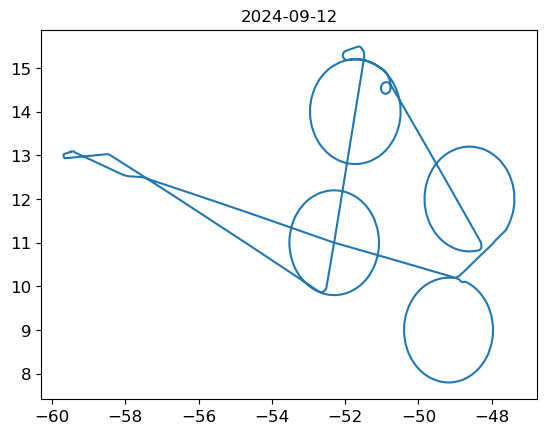

In [4]:
fig = plt.figure()
ax = fig.add_subplot()

plt.xticks(fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)

ax.plot(ds.lon,ds.lat)

plt.title(f"{pd.Timestamp(ds.time.values[0]).to_pydatetime():%Y-%m-%d}")
plt.show()

### Flight altitude difference

[5.8183 5.8184 5.8185 ... 5.6523 5.6522 5.652 ]


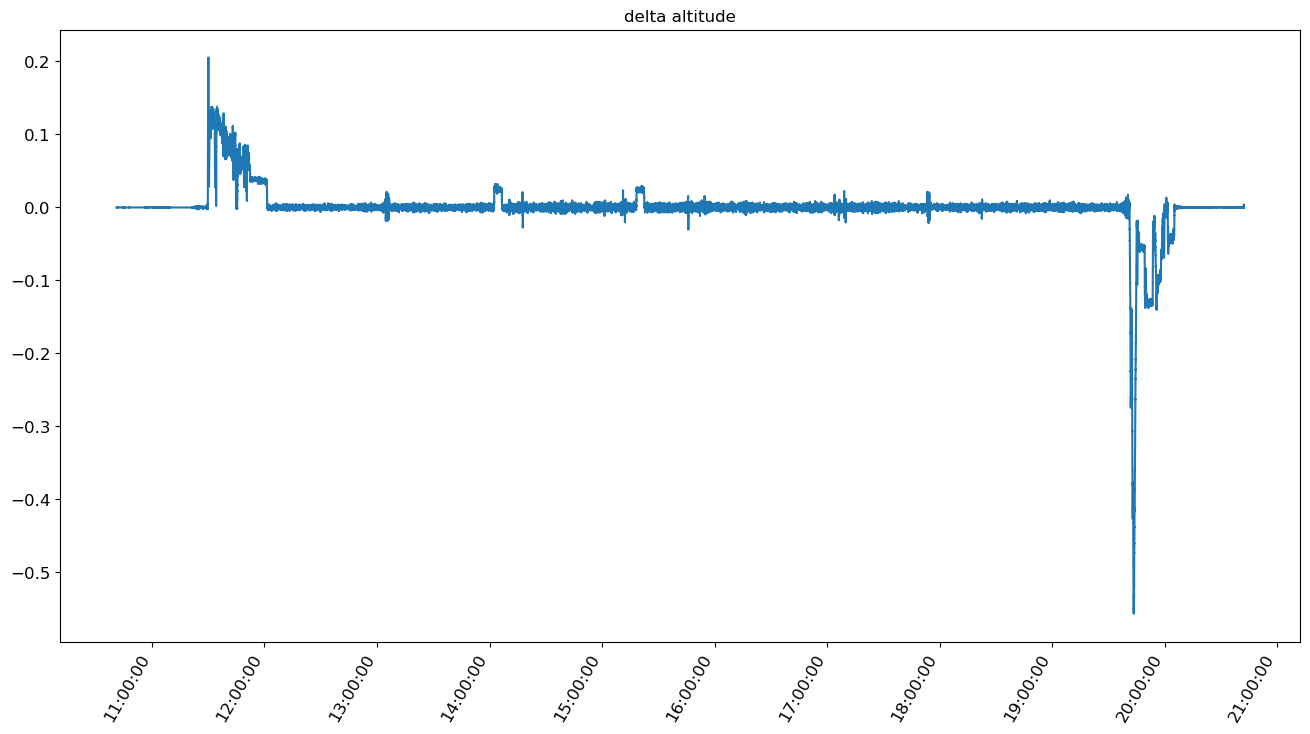

In [5]:
deltaalt = np.diff(ds.alt,n=1)
deltaalt = np.insert(deltaalt,0,0)

print (ds.alt.values)
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

resamplingTimeStr= str(resamplingTime)+'s'
ax.plot(ds.time,deltaalt)

timeFmt = DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(timeFmt)
plt.gcf().autofmt_xdate()

plt.xticks(rotation=60, fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)

plt.title("delta altitude")
plt.show()

### Delta flight heading

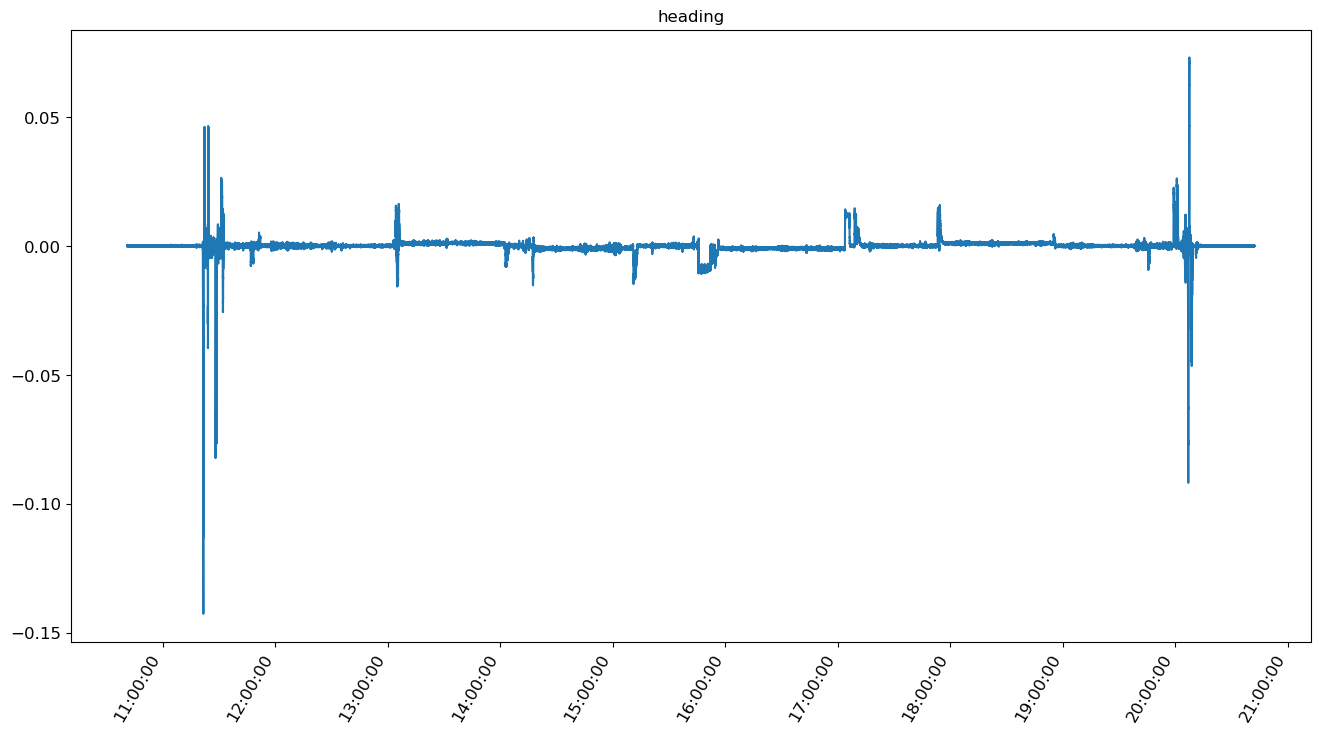

In [6]:
deltahead = np.diff(ds.heading,n=1)
deltahead = np.insert(deltahead,0,0)
deltahead = np.where( (deltahead >  359) , deltahead-360, deltahead)
deltahead = np.where( (deltahead < -359) , deltahead+360, deltahead)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

ax.plot(ds.time,deltahead)

timeFmt = DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(timeFmt)

plt.gcf().autofmt_xdate()

plt.xticks(rotation=60, fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)

plt.title("heading")

plt.show()

### Flight roll

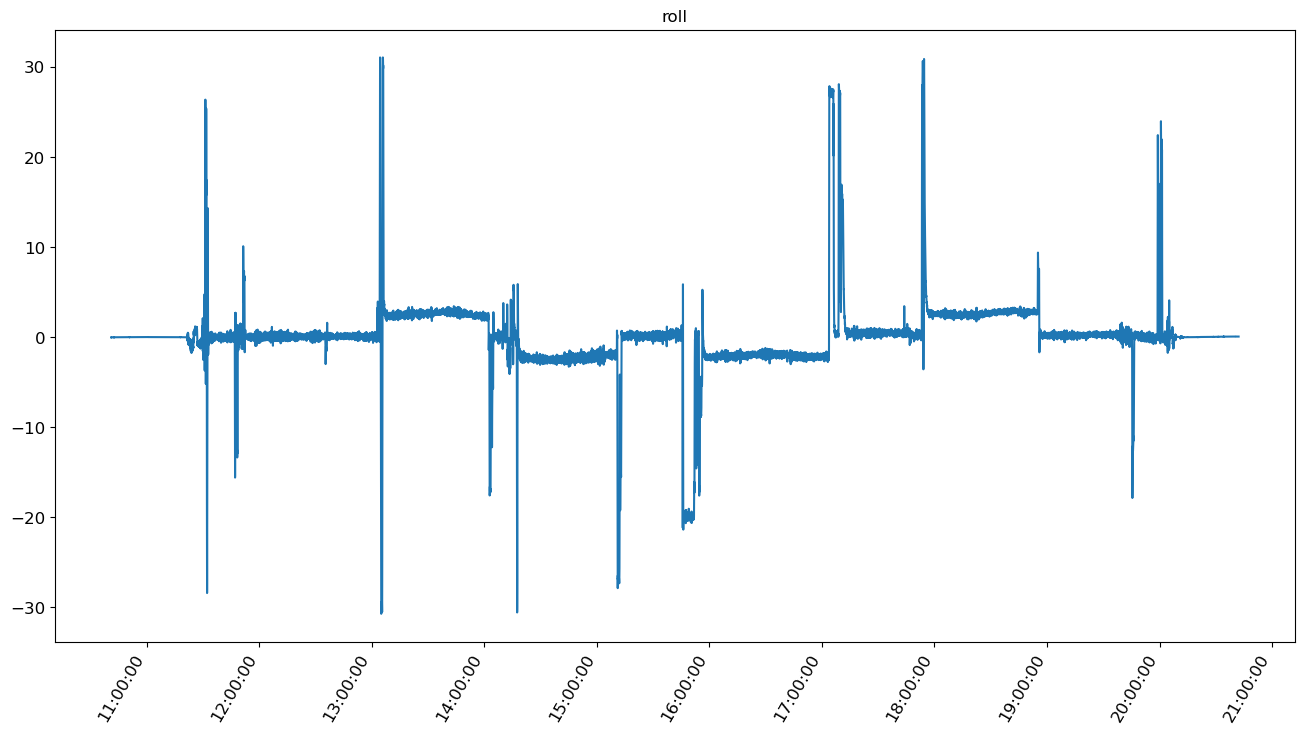

In [7]:
roll = ds['roll']

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

ax.plot(roll.time,roll)

timeFmt = DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(timeFmt)
plt.gcf().autofmt_xdate()

plt.xticks(rotation=60, fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)

plt.title("roll")
plt.show()

### Now get to the lines

In [8]:
smin=-0.004
smax= 0.004

slength = 1800*bahamasFreq
straight = np.ma.masked_where( ( deltahead < smin ) | ( deltahead > smax ) | ( ds.alt < 10 ) , deltahead )
slices = np.ma.flatnotmasked_contiguous(straight)

slices_start = np.array([s.start for s in slices])
slices_end   = np.array([s.stop  for s in slices])

j=0
segment=0
for i in slices_start:
    ibeg=i
    iend=slices_end[j]
    straight_length = iend-ibeg+1
    j += 1
    straight_start = ds.time[ibeg]
    straight_stop = ds.time[iend]
    if ( straight_length <= slength ) :
        for index in range(ibeg, iend):
            straight.mask[index] = True
    else :
        print (pd.Timestamp(straight_start.time.values).to_pydatetime() , " to ", pd.Timestamp(straight_stop.time.values).to_pydatetime())
        segment += 1 

2024-09-12 11:51:28.200000  to  2024-09-12 13:04:14.820000
2024-09-12 13:06:13.670000  to  2024-09-12 14:02:44.980000
2024-09-12 14:17:39.990000  to  2024-09-12 15:10:57.170000
2024-09-12 15:12:59.230000  to  2024-09-12 15:45:42.580000
2024-09-12 15:55:32.500000  to  2024-09-12 17:03:48.470000
2024-09-12 17:11:19.650000  to  2024-09-12 17:53:16.230000
2024-09-12 17:55:04.180000  to  2024-09-12 18:55:04.920000
2024-09-12 18:55:13.590000  to  2024-09-12 19:45:25.300000


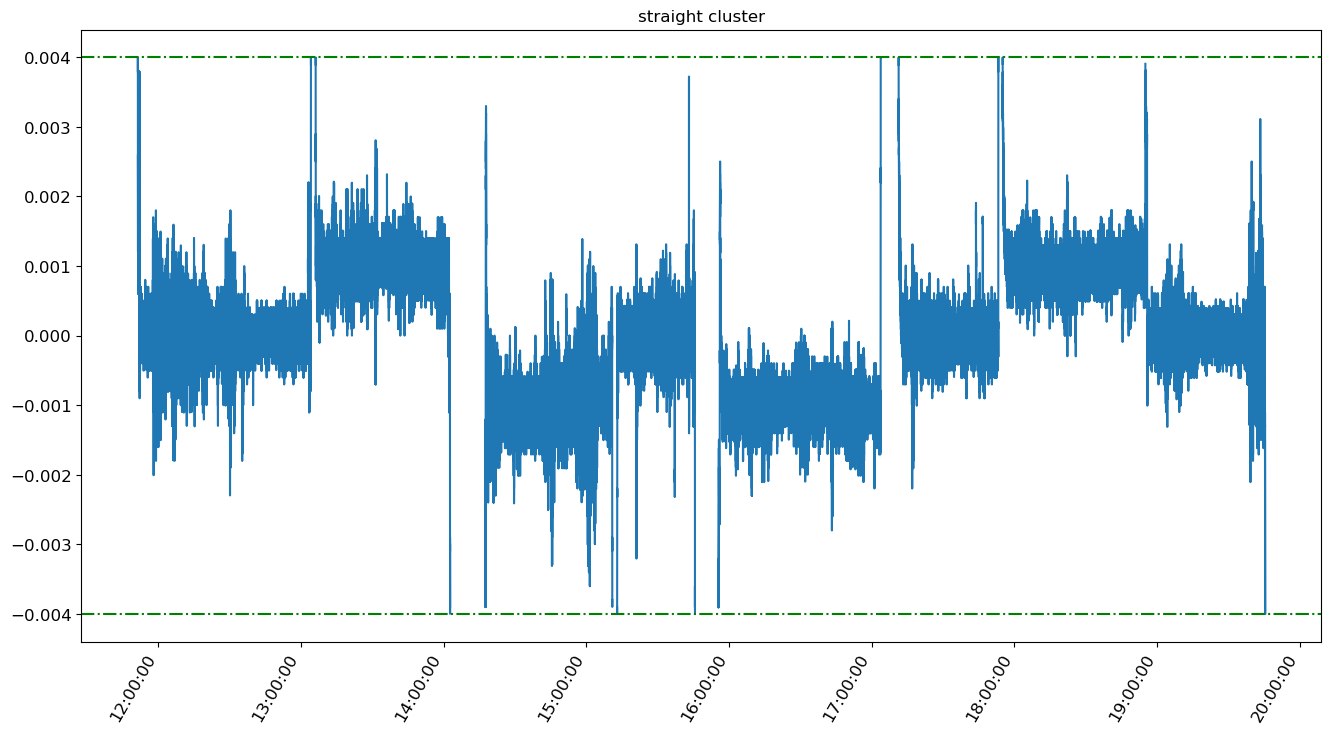

In [9]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

ax.plot(ds.time,straight)

timeFmt = DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(timeFmt)
plt.gcf().autofmt_xdate()

plt.xticks(rotation=60, fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)

plt.axhline(y=smax, color='g', linestyle='-.')
plt.axhline(y=smin, color='g', linestyle='-.')

plt.title("straight cluster")
plt.show()

### Start of straight line

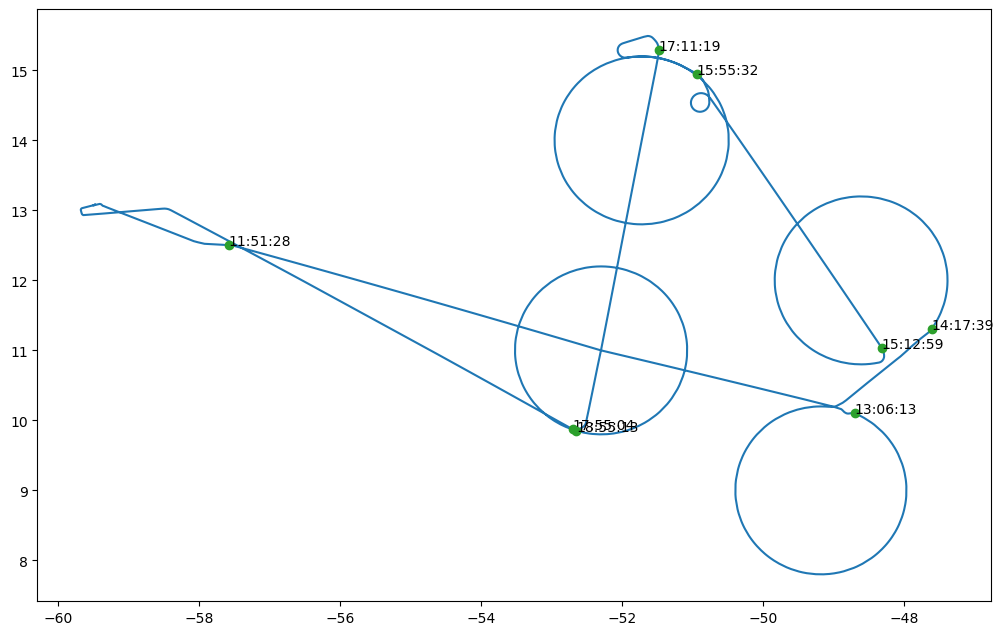

In [10]:
j=0
guessRange=0
trackResampling=1

minlat = np.min(ds.lat.values)
maxlat = np.max(ds.lat.values)
minlon = np.min(ds.lon.values)
maxlon = np.max(ds.lon.values)

xs=maxlon-minlon
ys=maxlat-minlat

fig = plt.figure(figsize=(xs,ys))
ax = fig.add_subplot()

ax.plot(ds.lon, ds.lat)

for i in slices_start:

    ibeg=i
    iend=slices_end[j]

    straight_length = iend-ibeg+1
    straight_start_bef = ds.time[ibeg-guessRange]
    straight_start_mid = ds.time[ibeg]
    straight_start_aft = ds.time[ibeg+guessRange]

    if ( straight_length > slength ) :

        point_bef = ds.isel(time=((ibeg-guessRange)*trackResampling))
        point_mid = ds.isel(time=( ibeg            *trackResampling))
        point_aft = ds.isel(time=((ibeg+guessRange)*trackResampling))

        # plt.xlim(point_mid.lon-1,point_mid.lon+1)
        # plt.ylim(point_mid.lat-1,point_mid.lat+1)

        ax.scatter(point_mid.lon, point_mid.lat, color="tab:green", zorder=3)
        ax.text(point_mid.lon, point_mid.lat, f"{pd.Timestamp(straight_start_mid.time.values).to_pydatetime():%H:%M:%S}")

        segment += 1

    j += 1

plt.show()

### End of straight line

In [ ]:
j=0
guessRange=0
trackResampling=1

fig = plt.figure(figsize=(xs,ys))
ax = fig.add_subplot()

ax.plot(ds.lon, ds.lat)

for i in slices_start:

    ibeg=i
    iend=slices_end[j]

    straight_length = iend-ibeg+1
    straight_end_bef = ds.time[iend-guessRange]
    straight_end_mid = ds.time[iend]
    straight_end_aft = ds.time[iend+guessRange]

    if ( straight_length > slength ) :

        point_bef = ds.isel(time=((iend-guessRange)*trackResampling))
        point_mid = ds.isel(time=( iend            *trackResampling))
        point_aft = ds.isel(time=((iend+guessRange)*trackResampling))

        # plt.xlim(point_mid.lon-1,point_mid.lon+1)
        # plt.ylim(point_mid.lat-1,point_mid.lat+1)

        ax.scatter(point_mid.lon, point_mid.lat, color="tab:red", zorder=3)
        ax.text   (point_mid.lon, point_mid.lat, f"{pd.Timestamp(straight_end_mid.time.values).to_pydatetime():%H:%M:%S}")

        segment += 1

    j += 1

plt.show()